# Hierarchical Clustering by Decade
@author: Thomas Lu, UC Berkeley; Nancy Xu, UC Berkeley<br>
@coauthors: Jaren Haber, PhD, Dartmouth College<br>
@contact: jhaber@berkeley.edu<br>
@project: Computational Literature Review of Organizational Scholarship<br>
@date_created: March 27, 2022
@date_modified: May 17, 2022

@description: '''Conducts hierarchical clustering (agglomerative) on the word vectors from pretrained word2vec models. Includes clusters seeded on expert-coded lexicons and clustering on only those seed terms. Visualize TSNE plots and dendrograms of the clusters.

@inputs: decade-specific word embedding models, core dictionaries <br>
@outputs: dendrograms/cluster visualizations
'''

## Import packages

In [1]:
import gensim # for word embedding models
import _pickle as cPickle # Optimized version of pickle
from collections import Counter # For counting terms across the corpus
import re # For filtering most_similar() output--remove surnames
import csv # For saving csv files
import pandas as pd
import numpy as np
import os
from itertools import combinations
from matplotlib import pyplot as plt
import seaborn as sns

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.manifold import TSNE # For visualizing word embeddings
from scipy.spatial import distance # To use cosine distances for tSNE metric
import scipy.cluster.hierarchy as shc
from scipy.cluster import hierarchy

import warnings
warnings.filterwarnings('ignore')

## Load models

In [2]:
wem_path1 = '../../models_storage/w2v_models/word2vec_phrased_filtered_enchant_300d_1970_1979_2022_oct30.bin'
wem_path2 = '../../models_storage/w2v_models/word2vec_phrased_filtered_enchant_300d_1980_1989_2022_oct30.bin'
wem_path3 = '../../models_storage/w2v_models/word2vec_phrased_filtered_enchant_300d_1990_1999_2022_oct30.bin'
wem_path4 = '../../models_storage/w2v_models/word2vec_phrased_filtered_enchant_300d_2000_2016_2022_oct30.bin'

m1 = KeyedVectors.load(wem_path1)
m2 = KeyedVectors.load(wem_path2)
m3 = KeyedVectors.load(wem_path3)
m4 = KeyedVectors.load(wem_path4)
models = [m1, m2, m3, m4]
# models = [m1, m2]

decades = [
    '1970-1979',
    '1980-1989',
    '1990-1999',
    '2000-2015',
]

In [3]:
# Load dictionaries
cult_core = pd.read_csv('../../dictionary_methods/dictionaries/core/cultural_core.csv', header=None)[0].apply(lambda x: x.replace(' ', '_'))
dem_core = pd.read_csv('../../dictionary_methods/dictionaries/core/demographic_core.csv', header=None)[0].apply(lambda x: x.replace(' ', '_'))
relt_core = pd.read_csv('../../dictionary_methods/dictionaries/core/relational_core.csv', header=None)[0].apply(lambda x: x.replace(' ', '_'))

# Local loading:
#cult_core = pd.read_csv("../nancyxu/cultural_core.txt", sep="\n", header=None)[0]
#dem_core = pd.read_csv("../nancyxu/demographic_core.txt", sep="\n", header=None)[0]
#relt_core = pd.read_csv("../nancyxu/relational_core.txt", sep="\n", header=None)[0]

In [4]:
all_core = set(pd.concat((cult_core, dem_core, relt_core)))
all_color_map = {label: 'r' for label in cult_core}
all_color_map.update({label: 'g' for label in dem_core})
all_color_map.update({label: 'b' for label in relt_core})

for label in all_core:
    if label in cult_core.values and label in dem_core.values:
        all_color_map.update({label: 'tab:gray'})
    if label in cult_core.values and label in relt_core.values:
        all_color_map.update({label: 'tab:gray'})
    if label in relt_core.values and label in dem_core.values:
        all_color_map.update({label: 'tab:gray'})

## Agglomerative Clustering 

### Define dendrogram functions for seed terms

In [114]:
def plot_dendrogram(model, 
                    linkage='average',
                    figsize=(20,10), 
                    color_labels=None, 
                    yrange=None, 
                    xrange=None,
                    title="Dendrogram", 
                    save_plot=None, 
                    **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    fig = plt.figure(figsize=figsize)
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    children, distances, counts = model.children_, model.distances_, np.array(counts)

    linkage_matrix = np.column_stack(
        [children, distances, counts]
    ).astype(float)
    
    cluster_threshold = 0.7*max(linkage_matrix[:,2])
    print(f'cluster threshold: {cluster_threshold}')

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    ax = plt.gca()
    
    # Customize plot layout by dendrogram orientation
    if yrange: # 'top' orientation
        ax.set_ylim(yrange)
        plt.axhline(y=cluster_threshold, c='k', linestyle='dashed')
        ax.set_xlabel(f'{linkage.title()} linkage distance', fontsize = 24)
        if color_labels:
            xlbls = ax.get_xmajorticklabels()
            for lbl in xlbls:
                lbl.set_color(color_labels.get(lbl.get_text(), 'black'))
                      
    elif xrange: # 'right' orientation
        ax.set_xlim(xrange)
        plt.axvline(x=cluster_threshold, c='k', linestyle='dashed')
        ax.set_ylabel(f'{linkage.title()} linkage distance', fontsize = 14)
        if color_labels:
            ylbls = ax.get_ymajorticklabels()
            for lbl in ylbls:
                lbl.set_color(color_labels.get(lbl.get_text(), 'black'))
    
    plt.title(title)
    if save_plot:
        filepath = "../figures/dendrograms/" + str(save_plot) + ".png"
#         print(filepath)
#         assert os.path.isfile(filepath)
        plt.savefig(filepath, bbox_inches='tight')
    plt.show()

def get_cluster_words(model, label, labels):
    words = []
    for i, word in enumerate(labels):
        if labels[i] == label:
            words.append(word)
    return words

In [115]:
def cluster_and_visualize(model, 
                          linkage='average', 
                          affinity='precomputed',
                          label_filter=None, 
                          color_map=None, 
                          figsize=(100, 5),
                          yrange=None,
                          xrange=None,
                          title=None,
                          save_plot=None,
                          orientation='top',
                          leaf_rotation=90,
                          leaf_font_size=12,
                          p=100,
                          n_clusters=4):
    vecs = []
    
    labels = []
    for word in model.wv.index_to_key:
        if label_filter and not label_filter(word):
            continue 
        labels.append(word)
        vecs.append(model.wv.get_vector(word))
        
    vecs = np.array(vecs)
    cos_dis = (1 - cosine_similarity(vecs, vecs))**3
    
    # Implementing hierarchical clustering
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters, 
        affinity=affinity, 
        linkage=linkage, 
        compute_full_tree=True,
        compute_distances=True).fit(cos_dis)
    
    # Create dendrogram
    plot_dendrogram(clustering, 
                    linkage=linkage,
                    figsize=figsize,
                    color_labels=color_map,
                    truncate_mode="level", 
                    title=title,
                    save_plot=save_plot,
                    p=p, 
                    labels=labels, 
                    leaf_rotation=leaf_rotation, 
                    yrange=yrange,
                    xrange=xrange,
                    show_leaf_counts=True, 
                    distance_sort=True,
                    leaf_font_size=leaf_font_size, 
                    orientation=orientation)
                    #color_threshold=0.7)

In [116]:
def core_term_dendro(model, 
                     decade, 
                     n_clusters=4, 
                     orientation='top',
                     save_plot=None):
    
    # make plot/file title and print
    title = f'dendro_core_terms_{decade}_n{n_cluster}_{orientation}' #f'Dendrogram of Core Terms from {decade} with n={n_cluster}'
    print(title)
    if save_plot:
        save_plot = title
        
    # derive dendrogram parameters
    if orientation == 'right':
        xrange=(0, 0.8)
        yrange=None
        figsize=(10, 20)
        leaf_rotation=0
        leaf_font_size=12
        orientation='right'
    elif orientation == 'top':
        xrange=None
        yrange=(0, 0.8)
        figsize=(30, 7)
        leaf_rotation=90
        leaf_font_size=24
        orientation='top'
        
    # execute clustering and dendrogram function
    cluster_and_visualize(model,
                          title=None, #title
                          linkage='average', 
                          affinity='precomputed',
                          label_filter=lambda x: x in all_core,
                          color_map=all_color_map, 
                          xrange=xrange,
                          yrange=yrange,
                          figsize=figsize, 
                          leaf_rotation=leaf_rotation,
                          leaf_font_size=leaf_font_size,
                          orientation=orientation,
                          n_clusters=n_clusters, 
                          save_plot=save_plot)

### Create decade dendrograms with core terms




dendro_core_terms_1970-1979_n4_top
cluster threshold: 0.5346318790629574


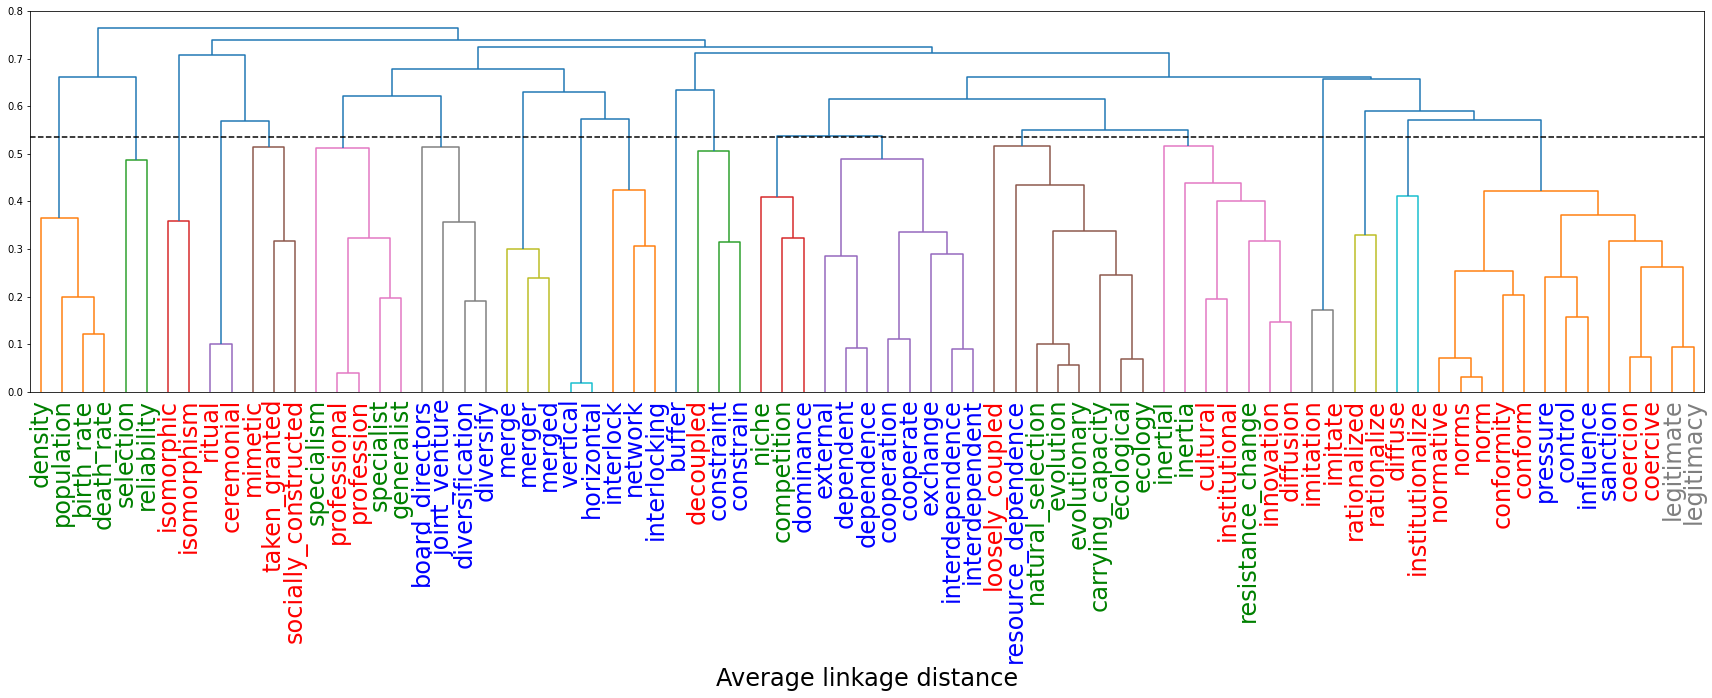




dendro_core_terms_1980-1989_n4_top
cluster threshold: 0.5205707848072052


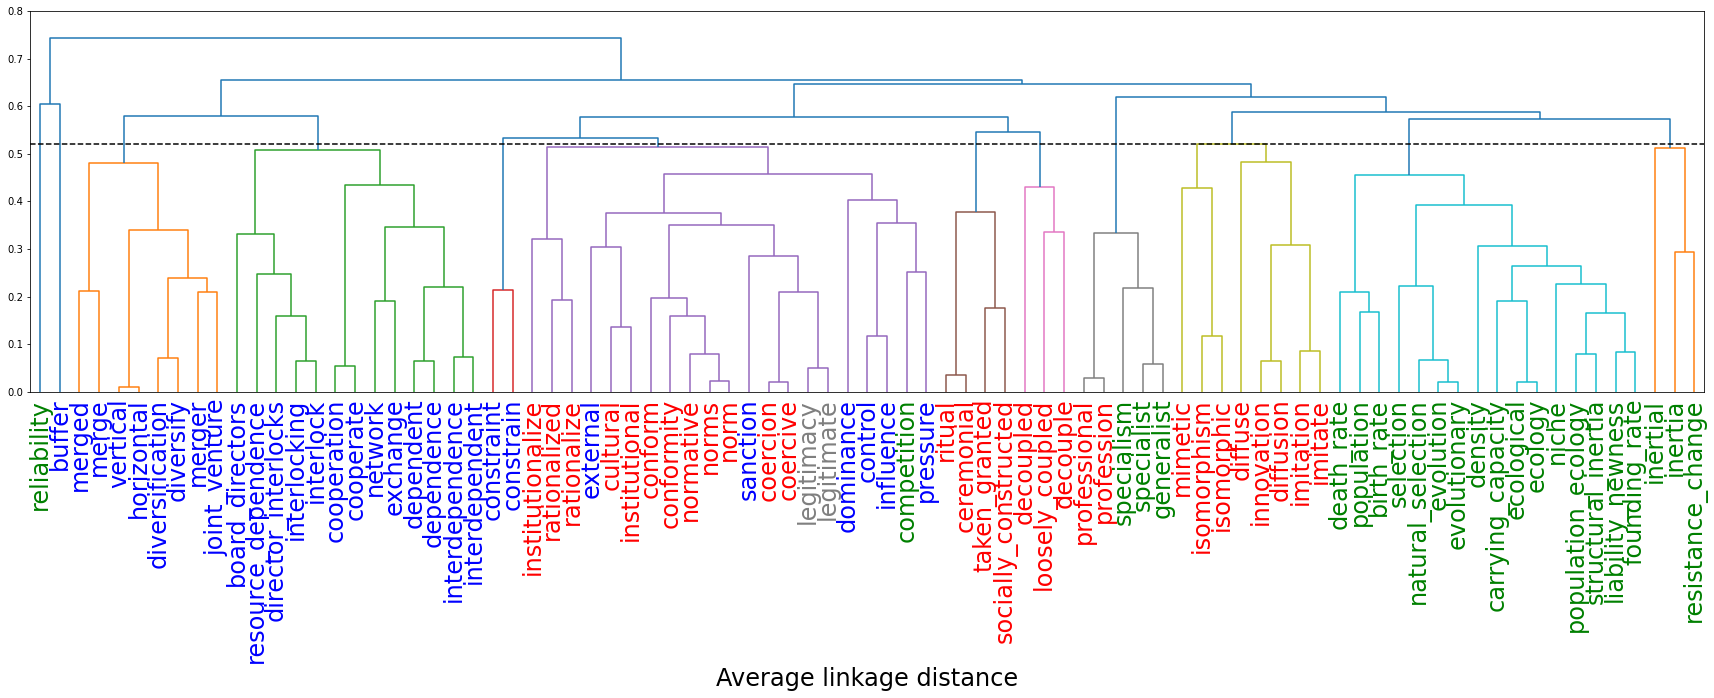




dendro_core_terms_1990-1999_n4_top
cluster threshold: 0.4943852101763089


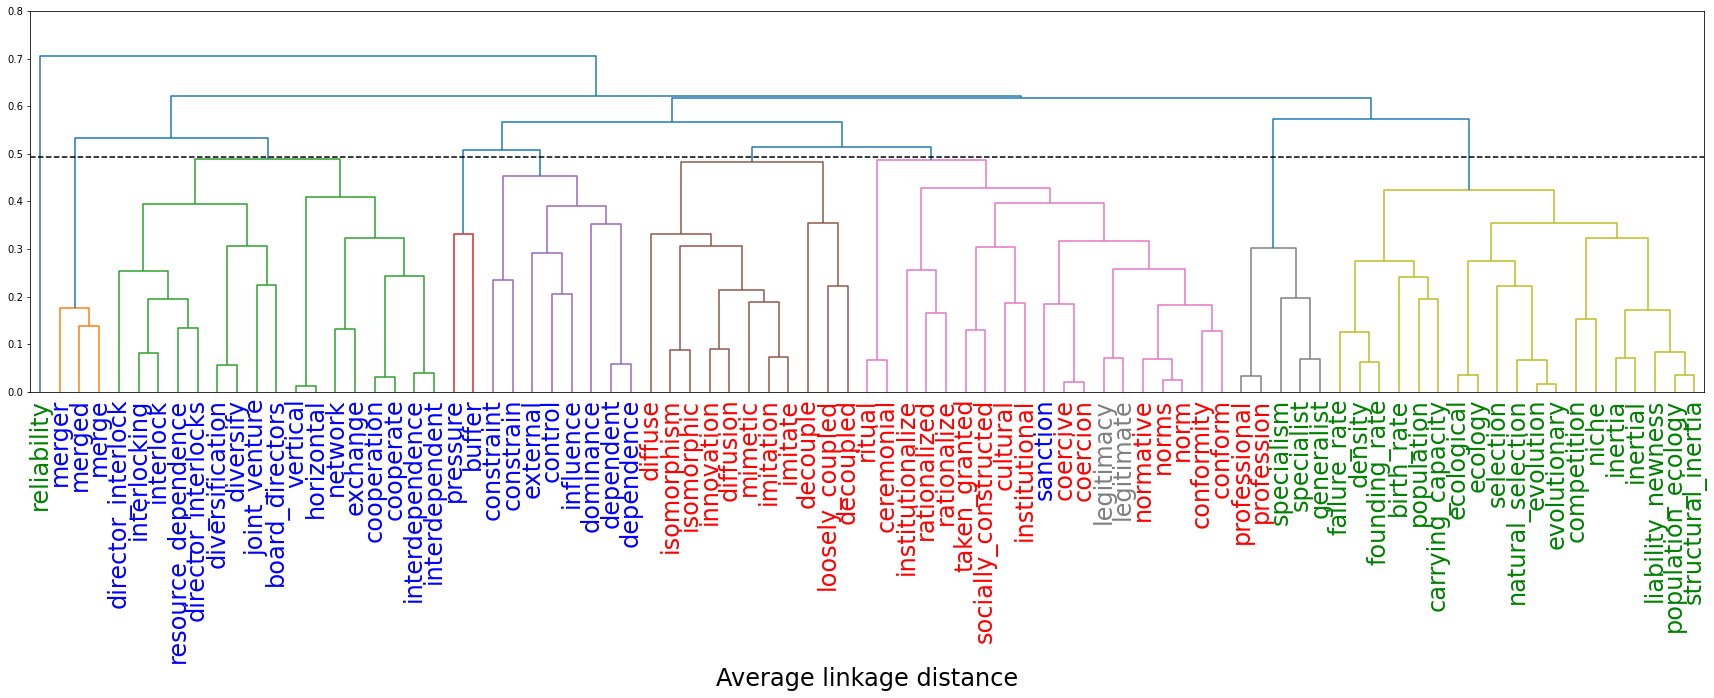




dendro_core_terms_2000-2015_n4_top
cluster threshold: 0.46854676245206806


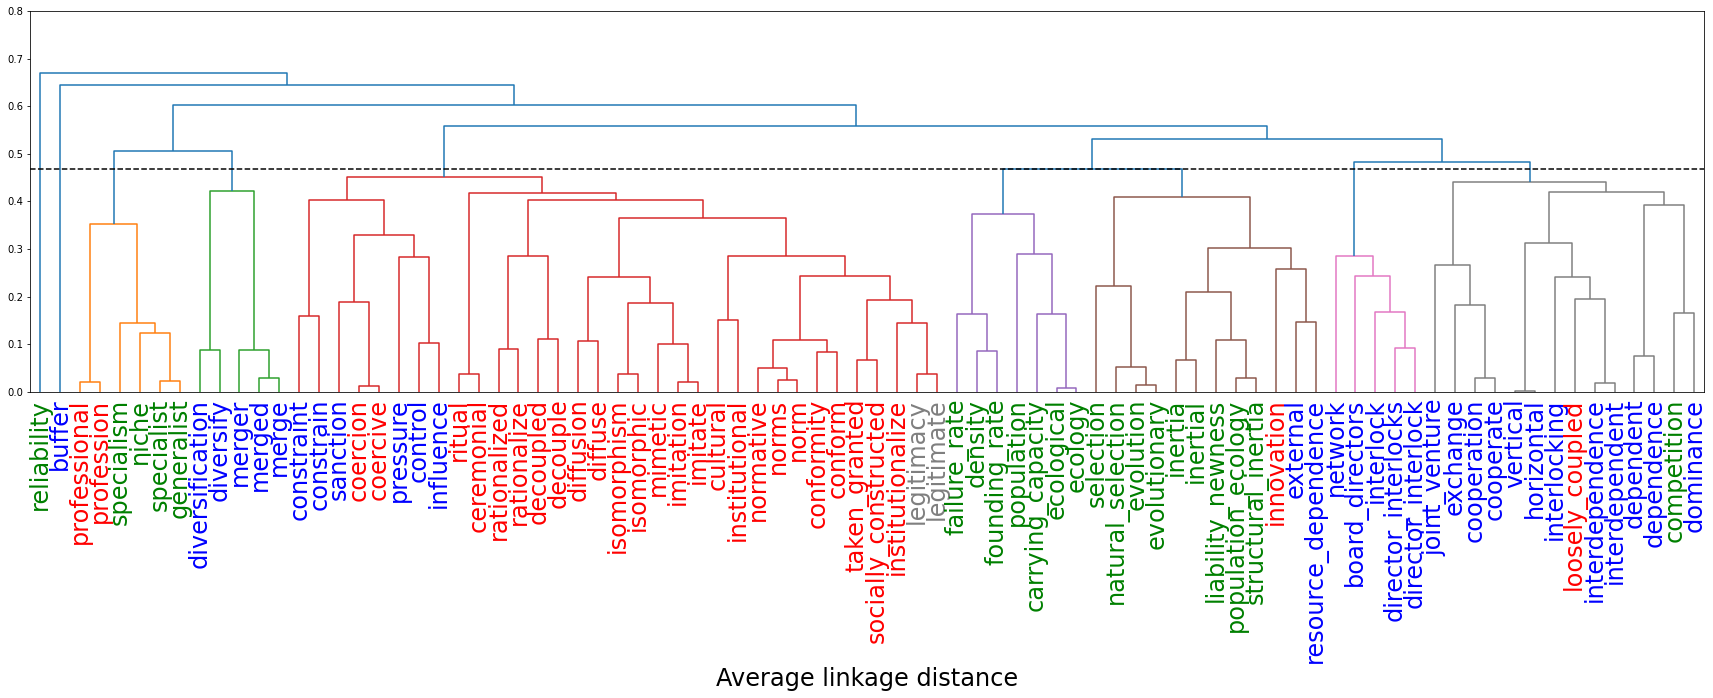

In [117]:
orientation = 'top' # define dendrogram orientation: labels below ('top') or to left ('right') of dendrogram

for model, decade in zip(models, decades):
    print('\n\n')
    for n_cluster in [4]: #[4, 6, 8, 10]:
        core_term_dendro(model, 
                         decade, 
                         n_cluster, 
                         orientation = orientation,
                         save_plot=True)

### Define dendrogram + TSNE functions for similar terms

In [9]:
def collect_ave_distance(d_mat, core, k, comb=np.min):
    
    words = core[:]
    for i in range(k):
        distances = comb(d_mat[words], axis=0).reshape(-1)
        inds = np.argpartition(distances, k+2)
        for idx in inds[:k+2]:
            if idx not in words:
                words.append(idx)
                break
    return words

In [10]:
def seed_clusters(model, 
                  seed_words,
                  k=50,
                  linkage='average', 
                  figsize=(80, 10),
                  title='Seed Clusters',
                  comb=np.min,
                  save=None,
                  p=100):
    
    seed_words = [word for word in seed_words if word in model.wv]
    
    vecs = []
    labels = []
    for word in model.wv.index_to_key:
        labels.append(word)
        vecs.append(model.wv.get_vector(word))
    
    vecs = np.array(vecs)
    cos_dis = (1 - cosine_similarity(vecs, vecs))
    
    for w1, w2 in combinations(seed_words, 2):
        cos_dis[model.wv.key_to_index[w1], model.wv.key_to_index[w2]] = 0.0
    
    idx = collect_ave_distance(cos_dis, [model.wv.key_to_index[w] for w in seed_words], k, comb=comb)
    
    cluster_words = np.array(labels)[idx]
    if save:
        save_words = pd.DataFrame(cluster_words)
        save_words.to_csv(save, index=False)
    
    ctitle = title + ' Similar Words Dendrogram'
    print(ctitle)
    cluster_and_visualize(model, label_filter=lambda x: x in cluster_words, 
                          p=p, figsize=figsize, linkage=linkage, title=ctitle,
                          color_map=all_color_map, yrange=(0, 0.8))
    
    ctitle = title + ' Similar Words T-SNE'
    print()
    show_tsne(model.wv, cluster_words, title=ctitle, color_map=all_color_map)

In [11]:
def show_tsne(model, words, title='T-SNE', core_words=(), color_map={}):
    
    arr = []
    word_labels = []

    # add the vector for each of the closest words to the array
    for wrd_label in words:
        if wrd_label not in model:
            continue
        arr.append( model[wrd_label] )
        word_labels.append(wrd_label)
    arr = np.array(arr)

    # find tsne coords for 2 dimensions, using cosine distances as metric
    tsne = TSNE(n_components=2, random_state=0, metric=distance.cosine)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    fig, ax = plt.subplots(figsize=(20,20))
    ax.scatter(x_coords, y_coords, alpha=1, s=100,
               c=[color_map.get(word, 'black') for word in word_labels])

    sns.set(style='white')

    for label, x, y in zip(word_labels, x_coords, y_coords):
        if label in core_words:
            ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontweight='bold').set_fontsize(20)
        else:
            ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points').set_fontsize(20)

    print(title)
    plt.title(title)
    ax.set_xlim(x_coords.min()+1, x_coords.max()+1)
    ax.set_ylim(y_coords.min()-1, y_coords.max()+1)
    ax.set_xlabel('t-SNE dimension 1')
    ax.set_ylabel('t-SNE dimension 2')
    ax.xaxis.label.set_fontsize(24)
    ax.yaxis.label.set_fontsize(24)
    xlbls = ax.get_xmajorticklabels()
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
    plt.show()

### Create dendrograms + TSNE for similar terms using Single Linkage

Cultural Terms in 1970-1979 Similar Words Dendrogram


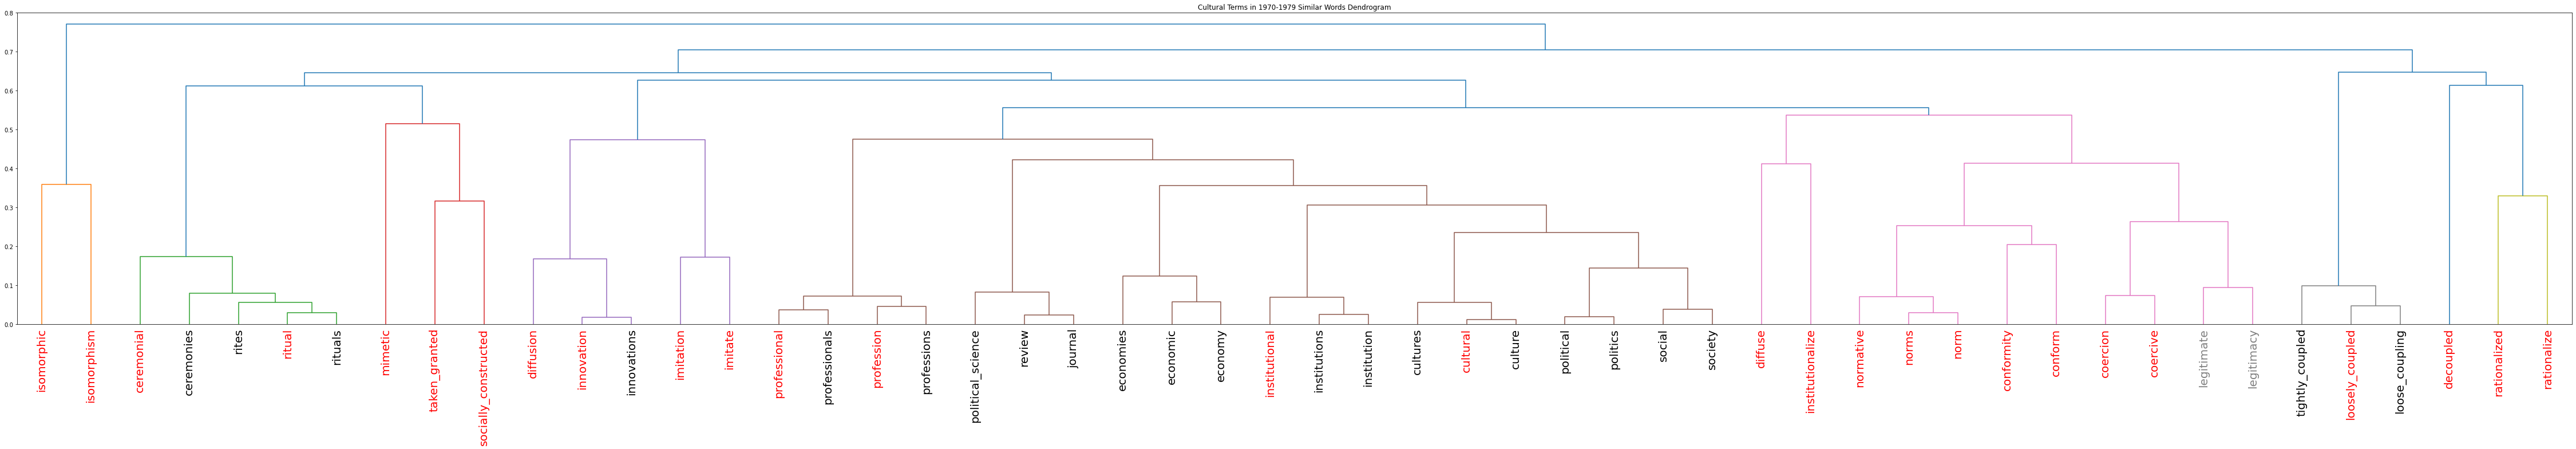


Cultural Terms in 1970-1979 Similar Words T-SNE


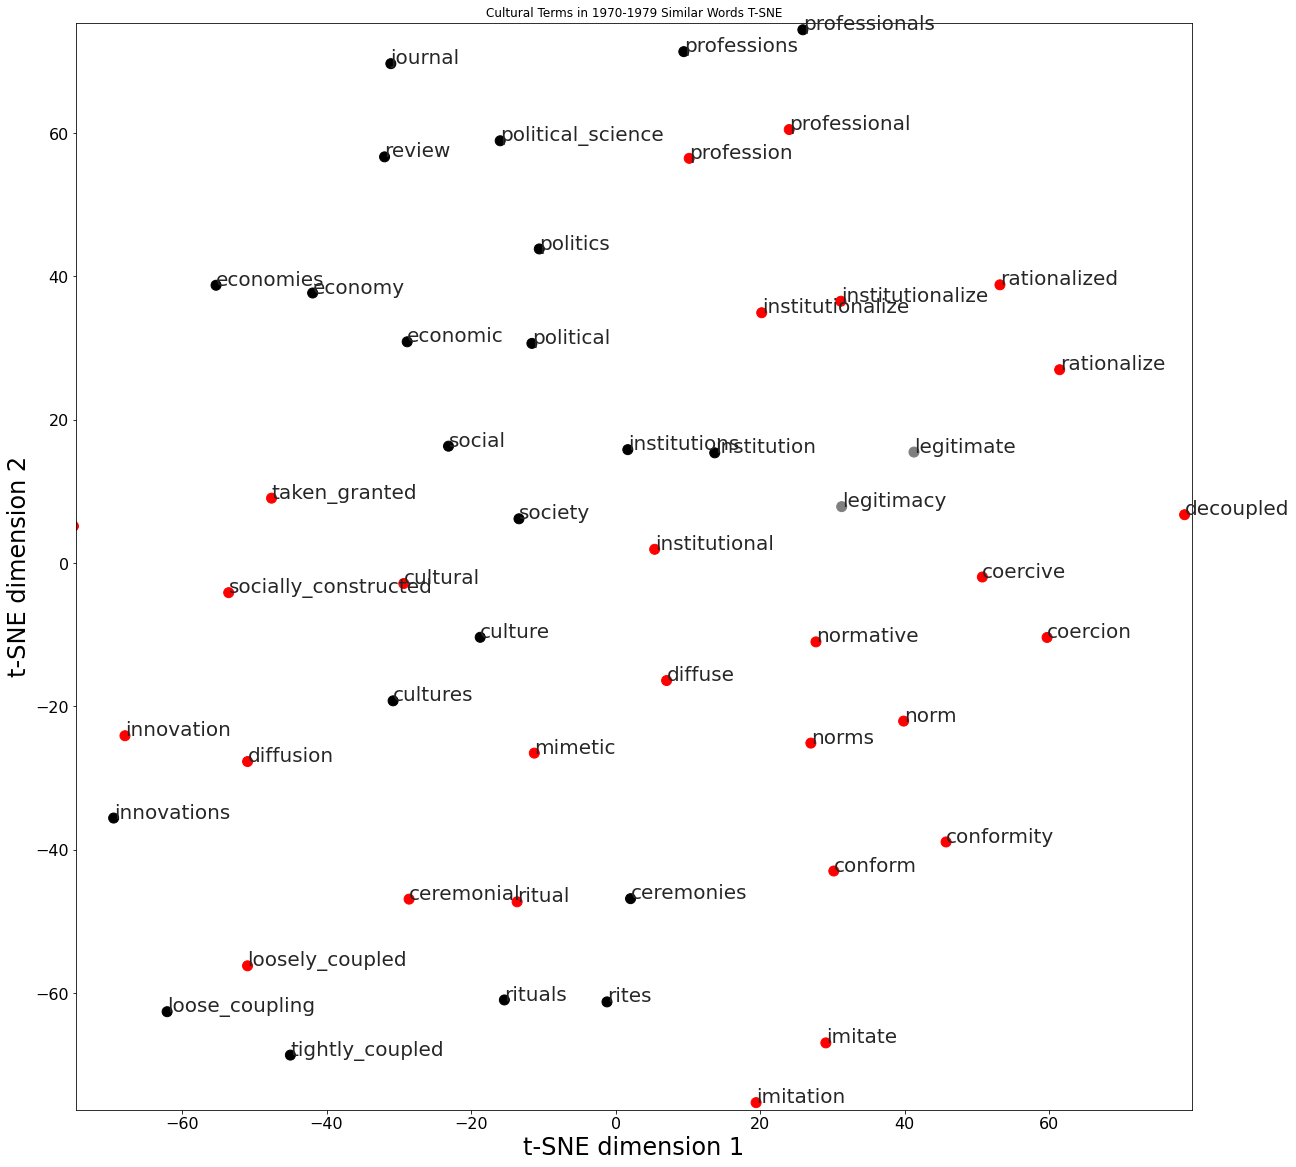

Demographic Terms in 1970-1979 Similar Words Dendrogram


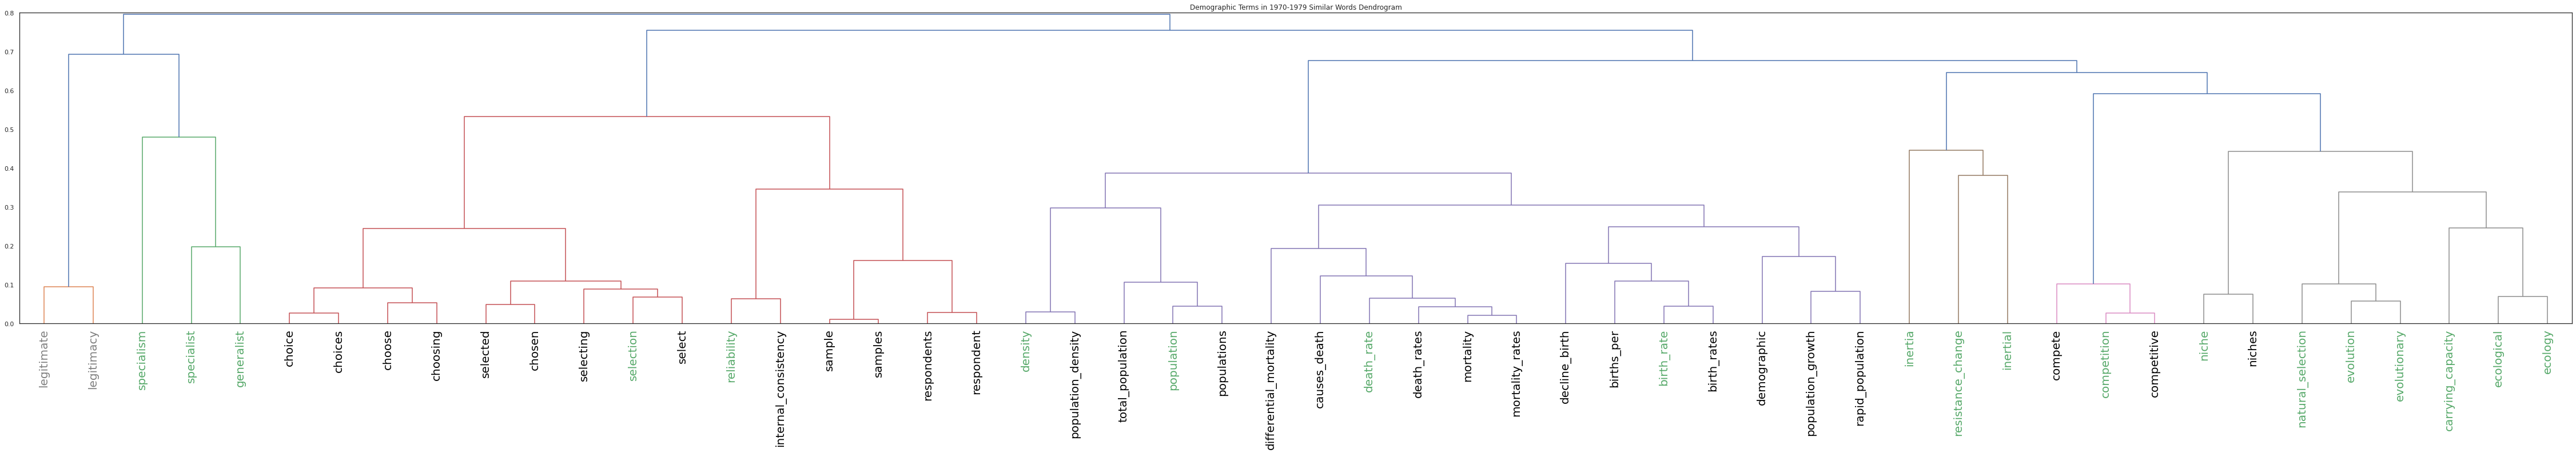


Demographic Terms in 1970-1979 Similar Words T-SNE


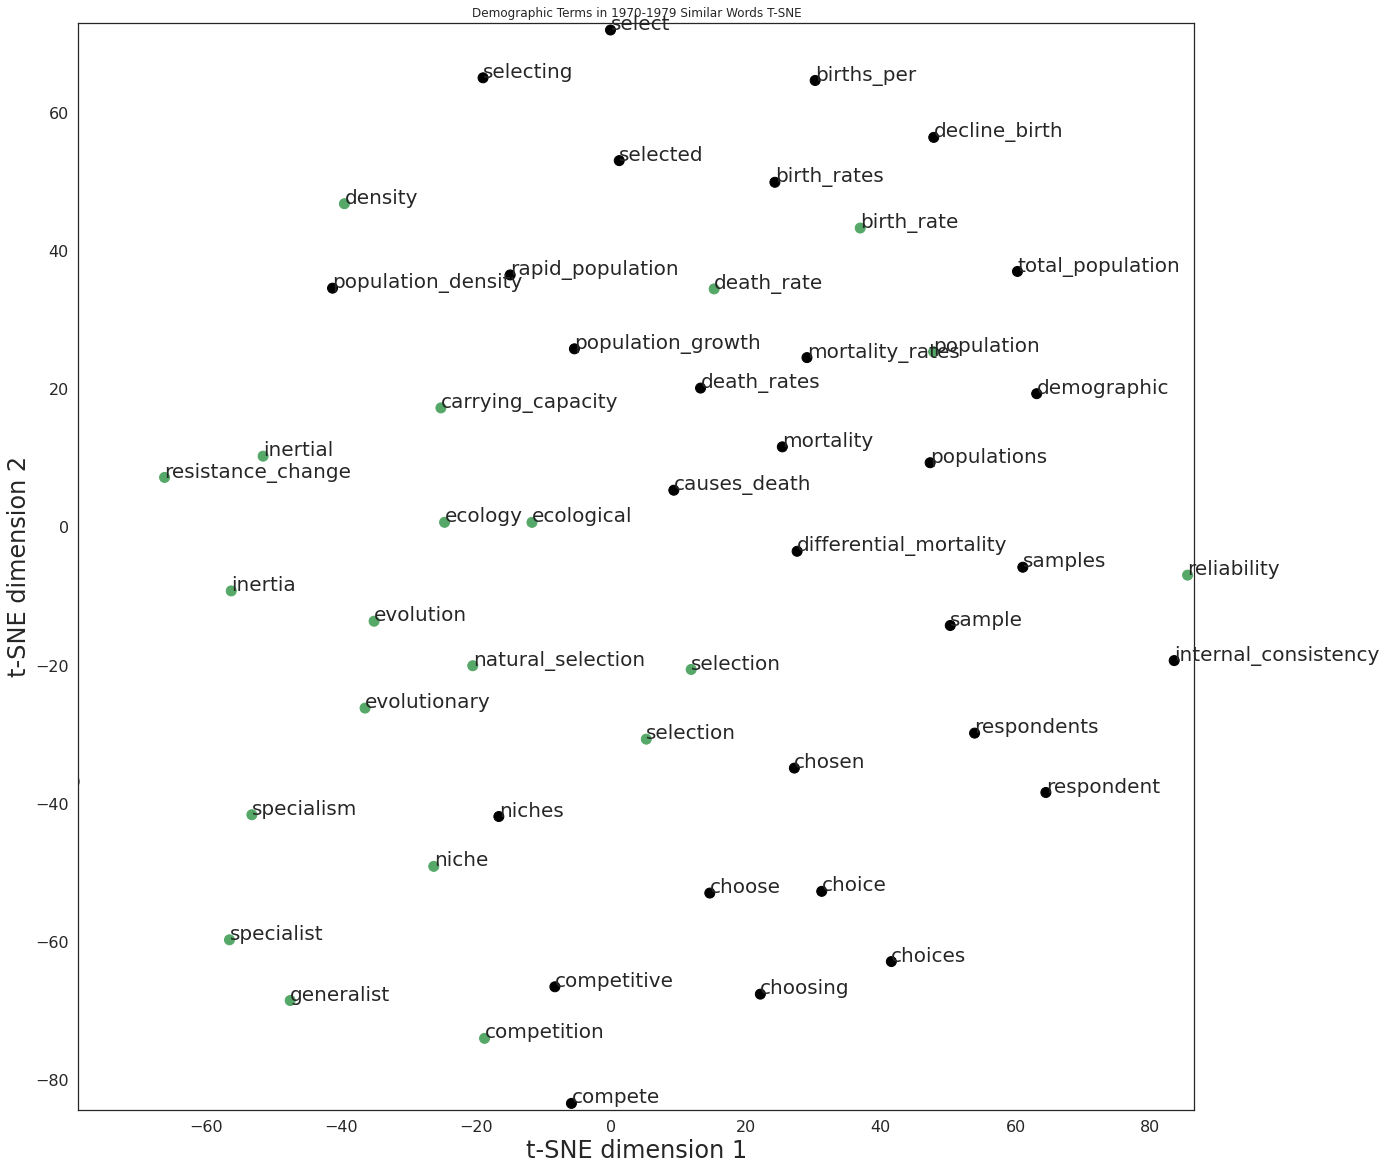

Relational Terms in 1970-1979 Similar Words Dendrogram


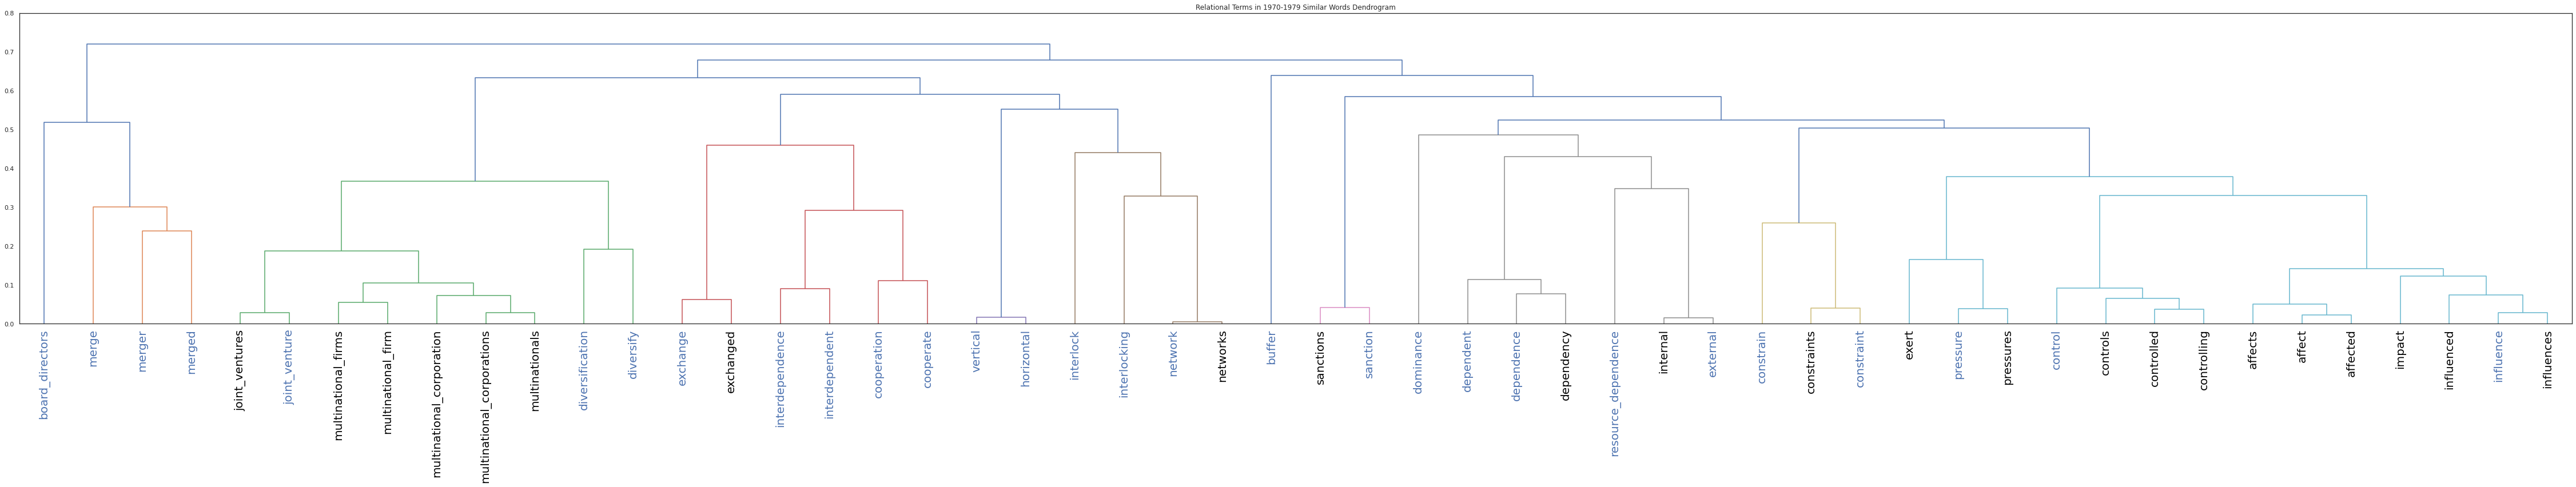


Relational Terms in 1970-1979 Similar Words T-SNE


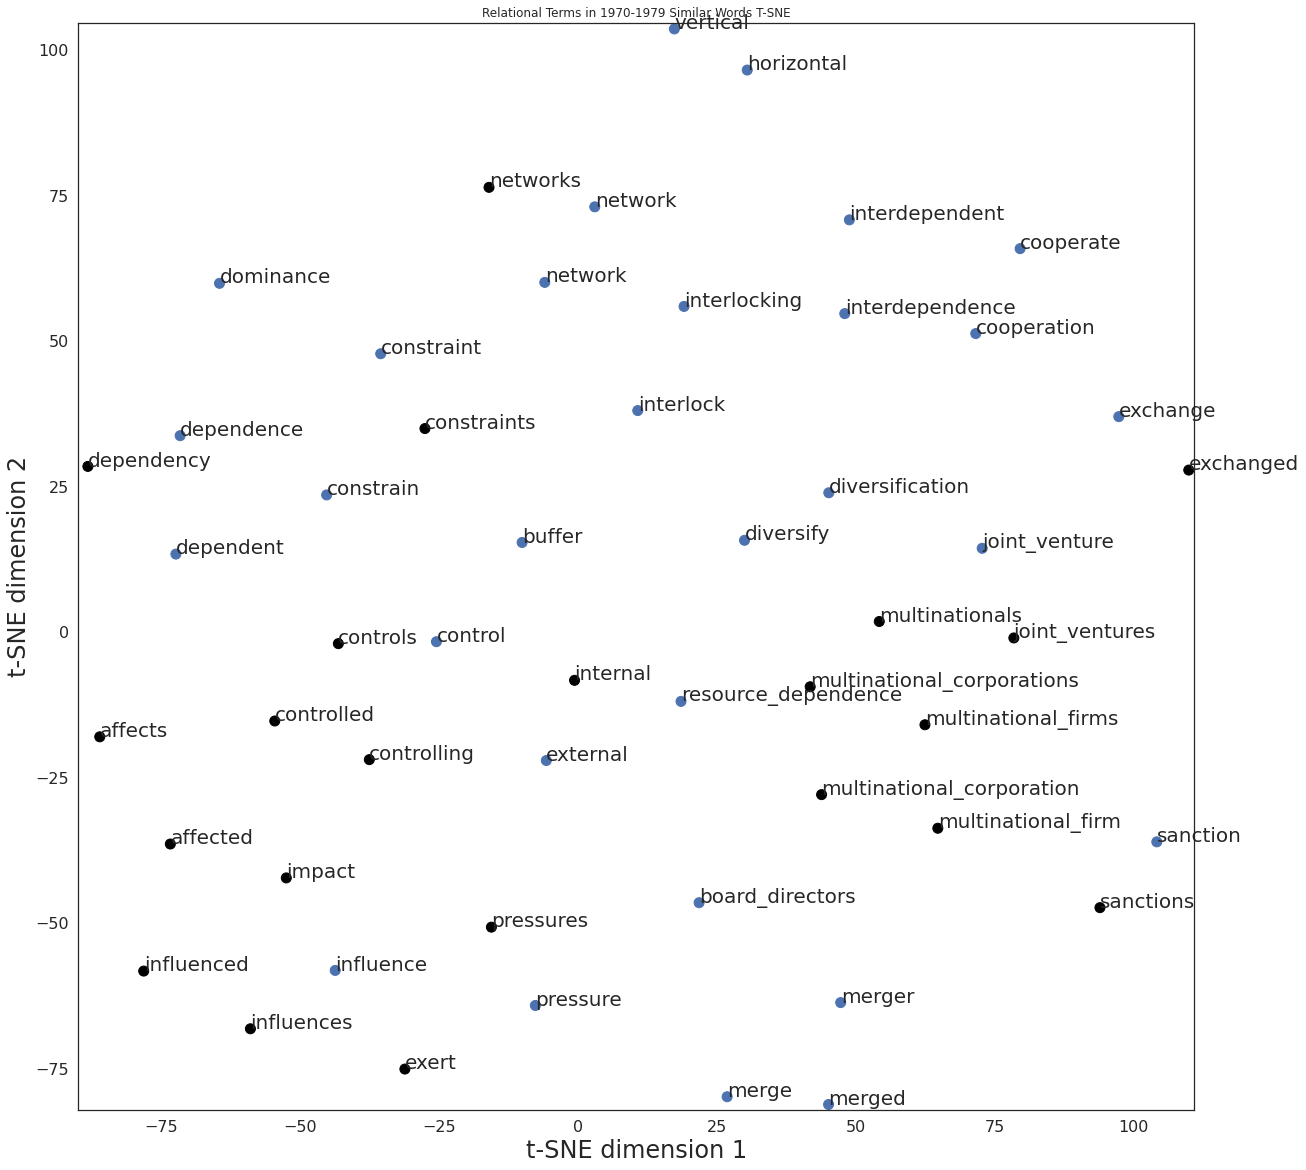

Cultural Terms in 1980-1989 Similar Words Dendrogram


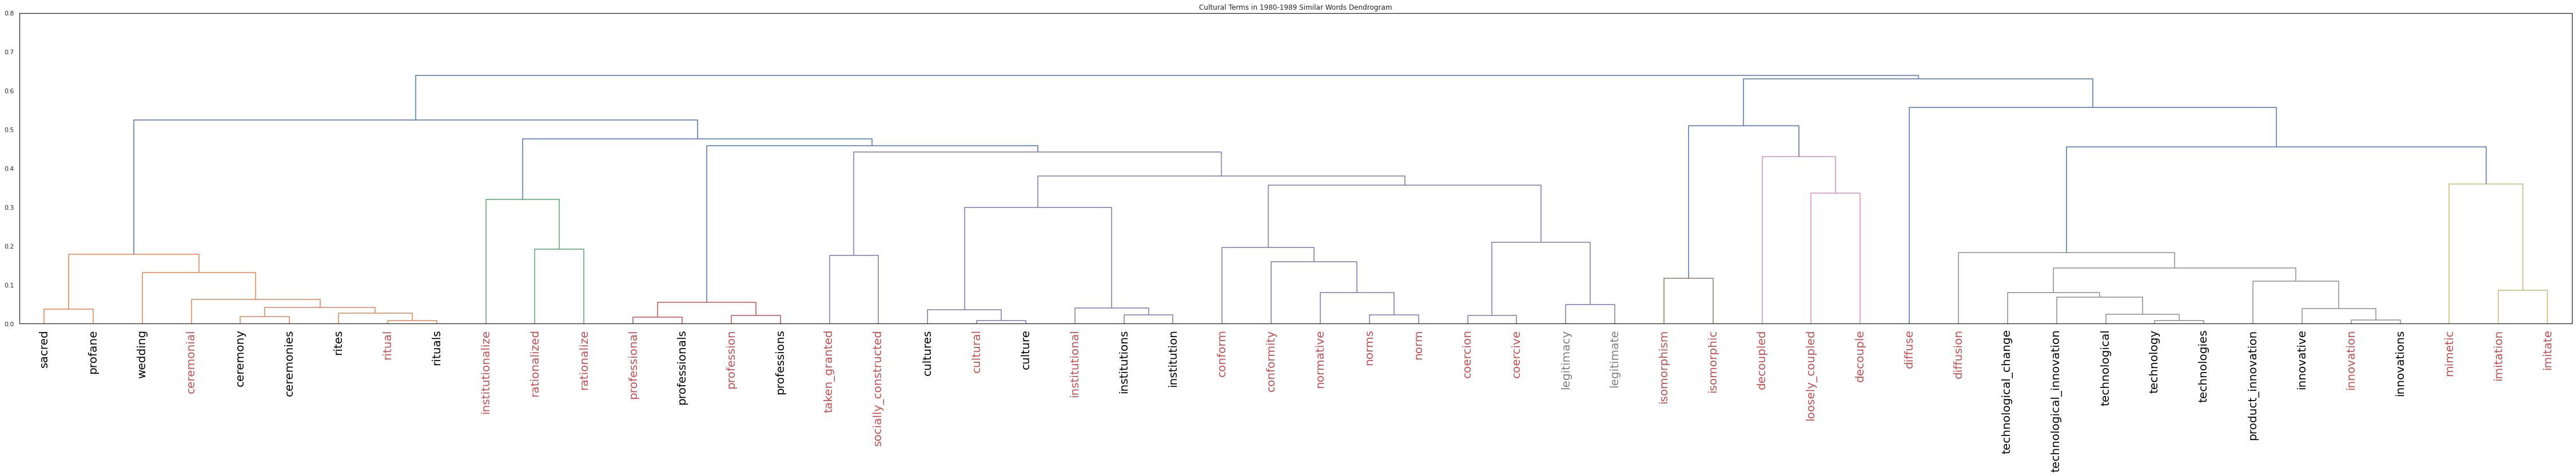


Cultural Terms in 1980-1989 Similar Words T-SNE


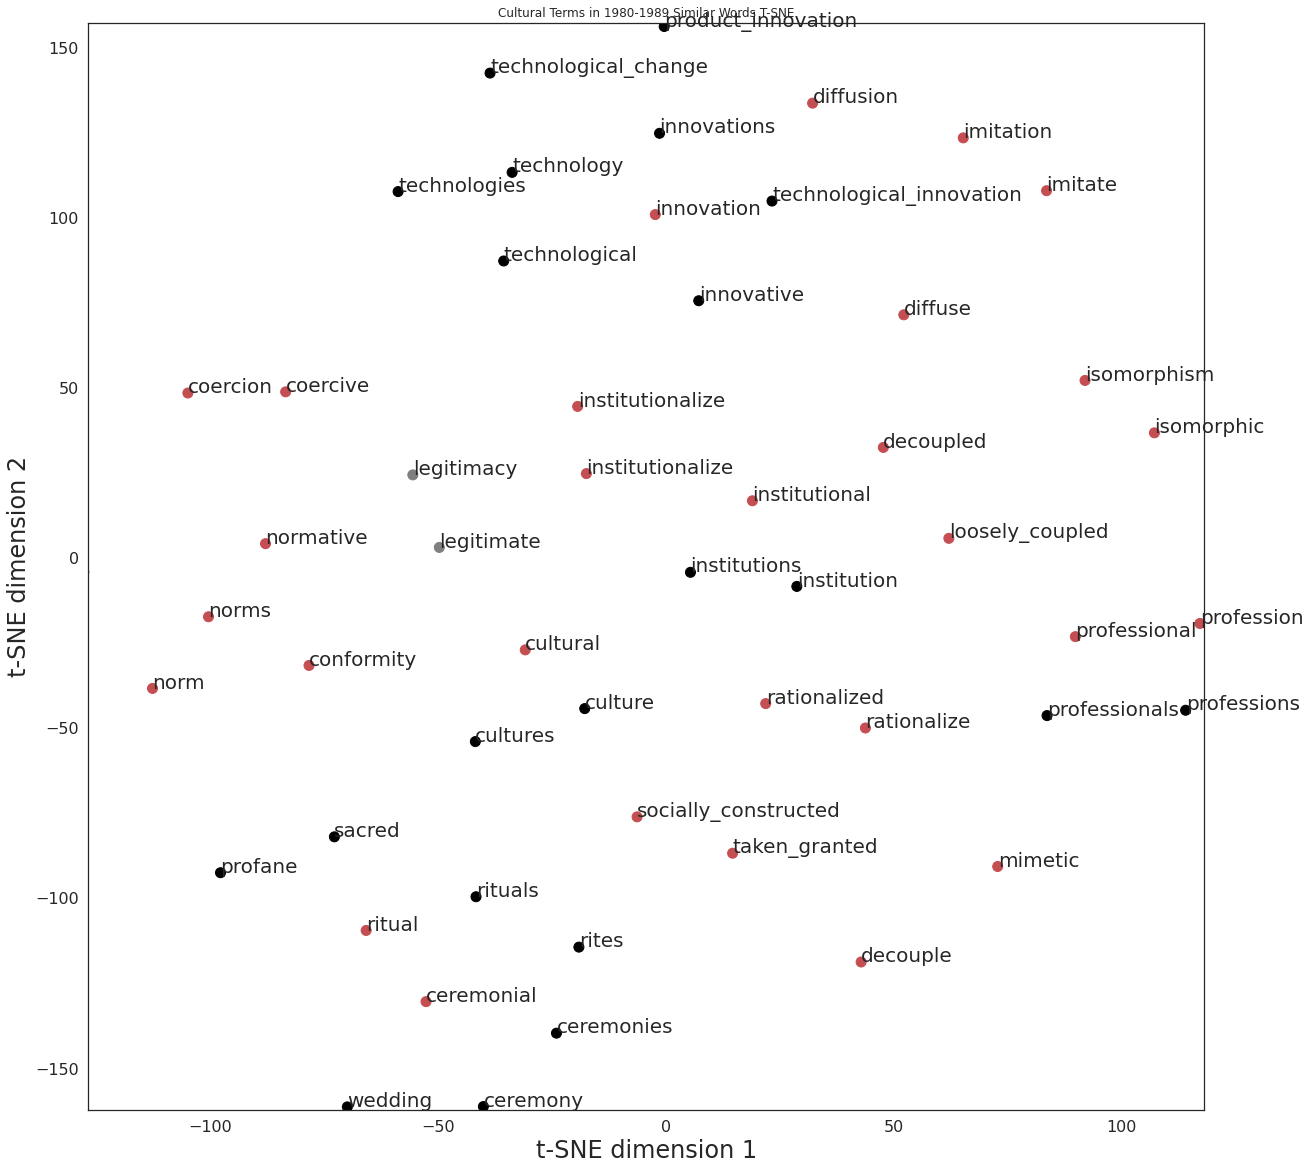

Demographic Terms in 1980-1989 Similar Words Dendrogram


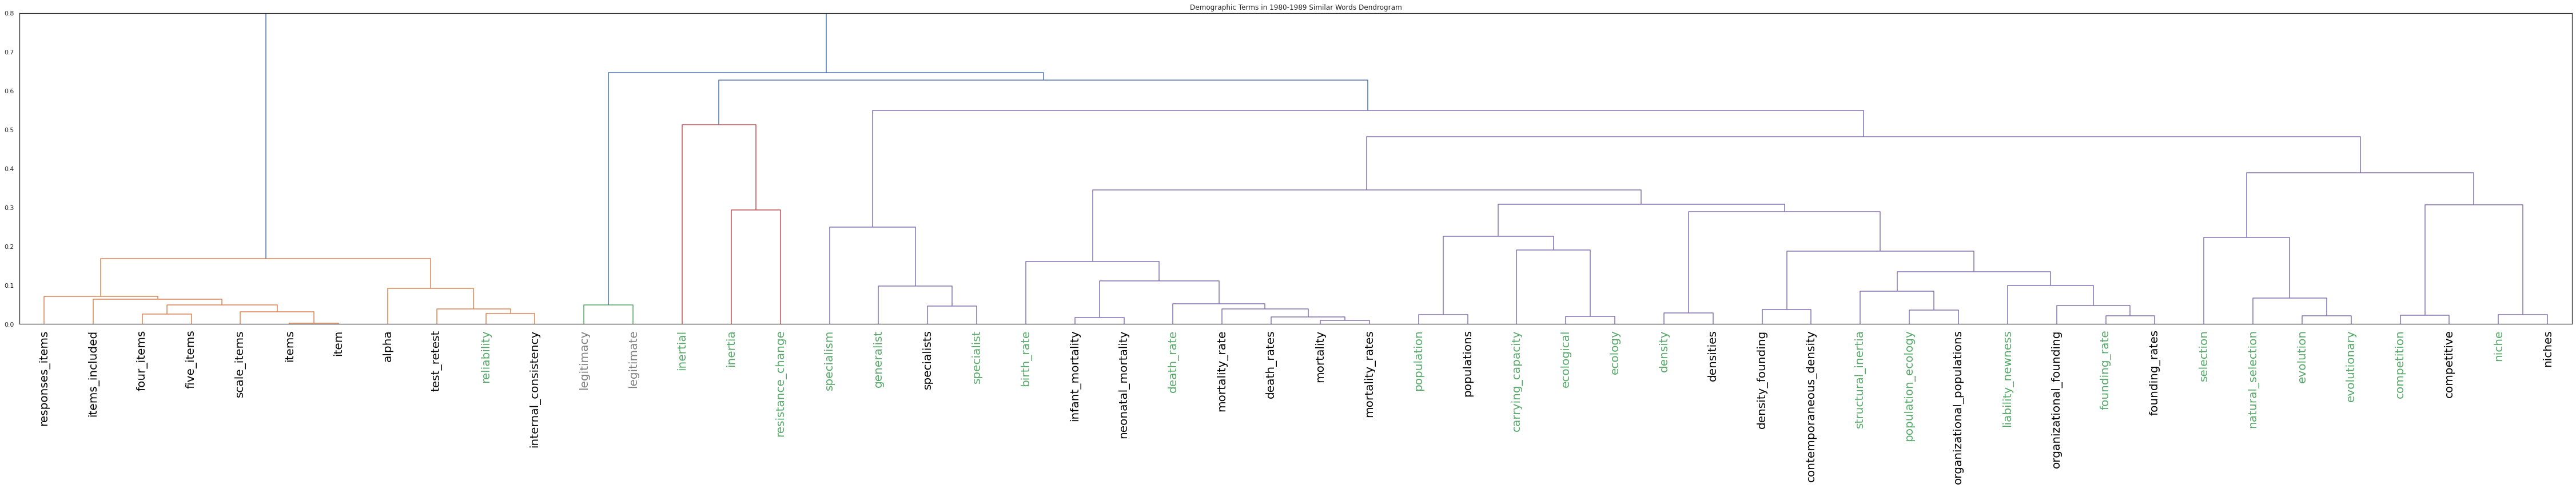


Demographic Terms in 1980-1989 Similar Words T-SNE


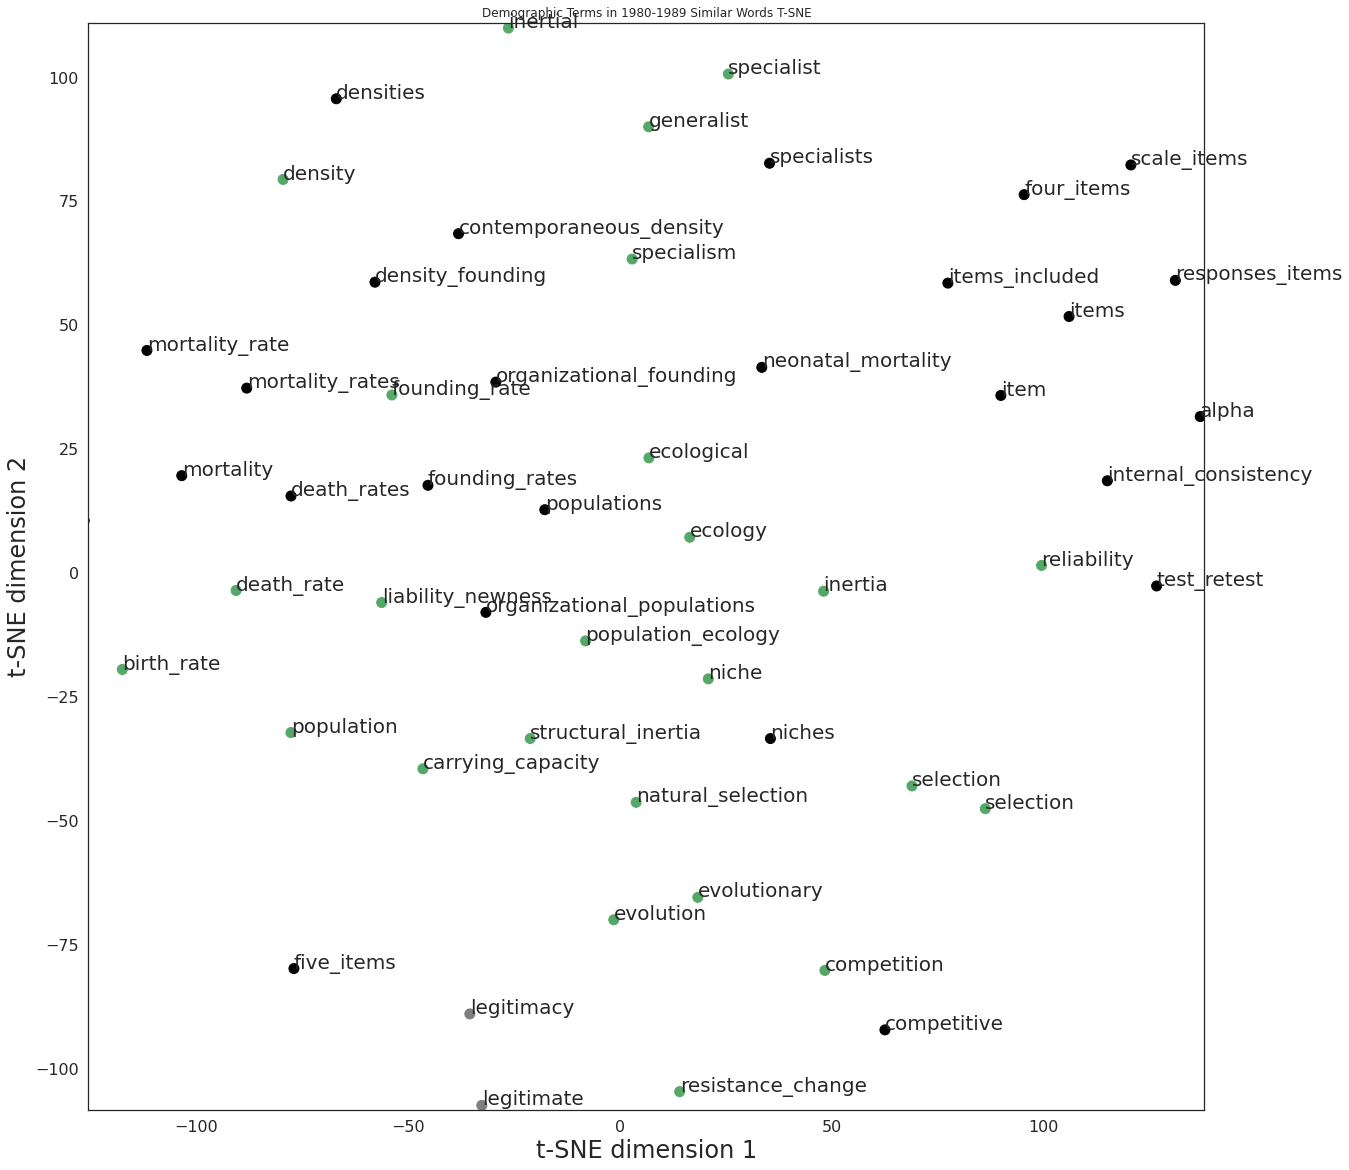

Relational Terms in 1980-1989 Similar Words Dendrogram


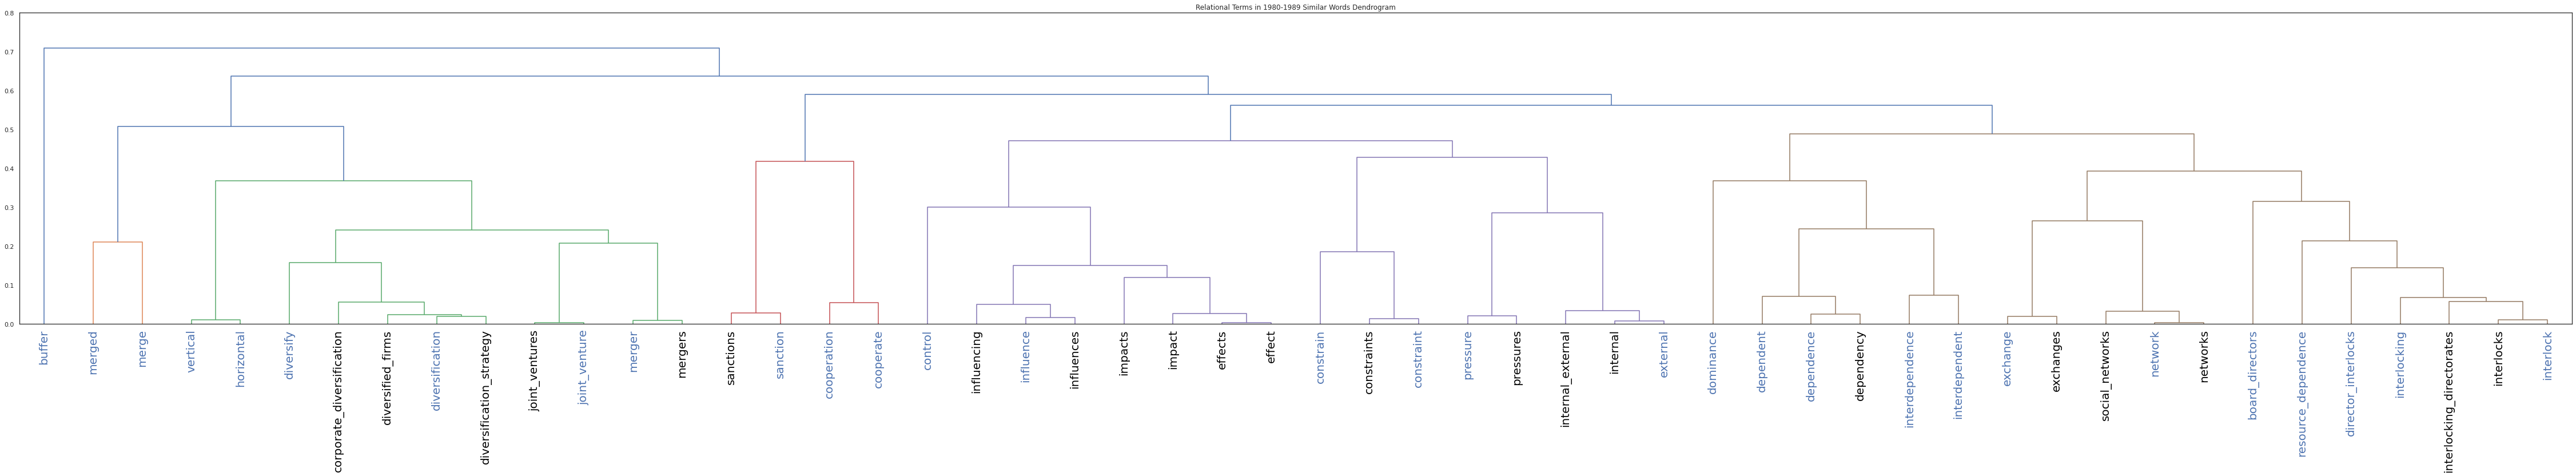


Relational Terms in 1980-1989 Similar Words T-SNE


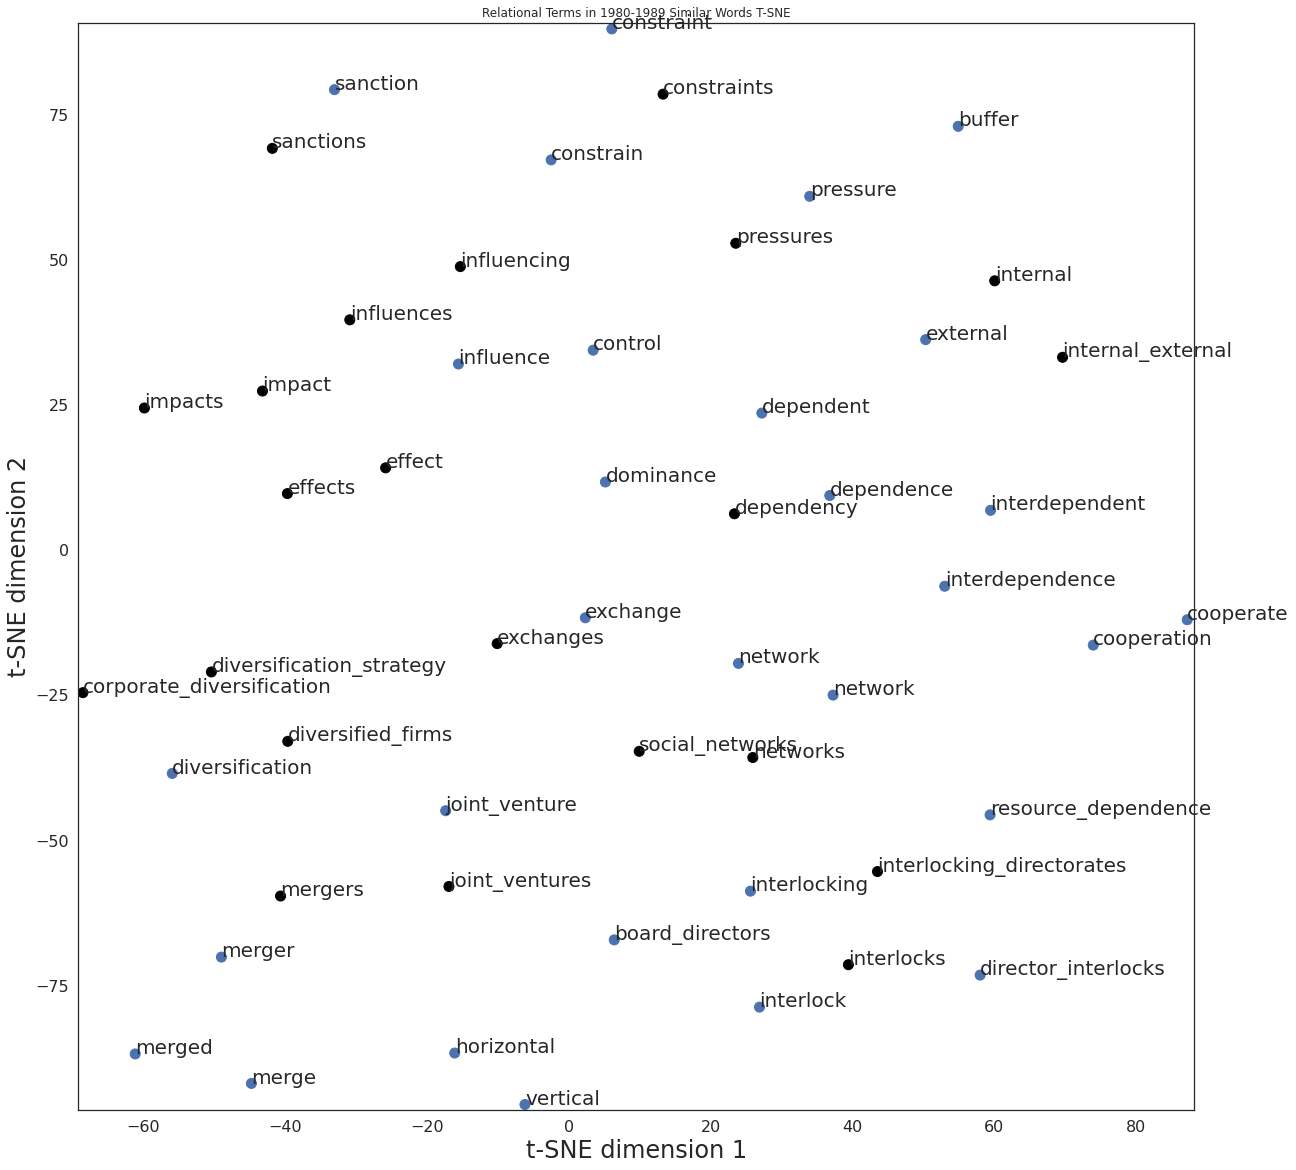

MemoryError: Unable to allocate 90.3 GiB for an array with shape (155649, 155649) and data type float32

In [12]:
for model, decade in zip(models, decades):
    for core, title in zip([cult_core, dem_core, relt_core], ['Cultural', 'Demographic', 'Relational']):
        seed_clusters(model, core, k=50,title=f'{title} Terms in {decade}',
#                      save=f'../figures/linked_words/{title}-{decade}-single.csv',
                      p=50)

### Create dendrograms + TSNE for similar terms using average linkage

In [ ]:
for model, decade in zip(models, decades):
    for core, title in zip([cult_core, dem_core, relt_core], ['Cultural', 'Demographic', 'Relational']):
        seed_clusters(model, core, k=30,title=f'{title} Terms in {decade}',
#                      save=f'../figures/linked_words/{title}-{decade}-average.csv', 
                      p=50, comb=np.mean)

In [ ]:
def decade_core_TSNE(model, title="Core T-SNE"):
    show_tsne(model.wv, all_core, title, color_map=all_color_map)

In [ ]:
for model, decade in zip(models, decades):
    decade_core_TSNE(model, title="Core Terms in "+decade)

## Validation: Alternative hierarchical clustering algorithm

In [ ]:
def plot_hierarchical_dendrogram_core(model, year, linkage):
    
    label_filter=lambda x: x in all_core
    vecs = []
    labels = []
    for word in model.wv.index_to_key:
        if label_filter and not label_filter(word):
            continue 
        labels.append(word)
        vecs.append(model.wv.get_vector(word))

    vecs = np.array(vecs)
    cos_dis = (1 - cosine_similarity(vecs, vecs))**3
    
    Z = hierarchy.linkage(cos_dis, linkage)
    
    plt.figure(figsize = (15,3))
    dn = hierarchy.dendrogram(Z,above_threshold_color='#bcbddc', labels=labels)

    # Assignment of colors to labels: 'a' is red, 'b' is green, etc.
    label_colors = all_color_map

    ax = plt.gca()
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

    ax.tick_params(axis='x', which='major', labelsize=15)
    ax.tick_params(axis='y', which='major', labelsize=8)
    
    plt.title('dendrogram of core terms (hierarchical clustering) ' + year)
    plt.show()


In [ ]:
years = ['1970-1979', '1980-1989','1990-1999','2000-2015']

In [ ]:
## single linkage
for i in np.arange(4):
    plot_hierarchical_dendrogram_core(models[i], years[i], 'single')

In [ ]:
## average linkage
for i in np.arange(4):
    plot_hierarchical_dendrogram_core(models[i], years[i], 'average')

In [ ]:
def remove_terms(seed_lst, m):
    for i in range(5):
        for word in seed_lst:
            try: 
                if m.wv.key_to_index[word] > 0:
#                     print('in vocab')
                    pass
            except:
                    seed_lst.remove(word)
                    # print("Removed " + str(word) + " from demog dictionary.")
        # Repeat for quality (second pass sometimes catches more):
        for word in seed_lst:
            try: 
                if m.wv.key_to_index[word] > 0:
                    pass
#                     print('in vocab')
            except:
                    seed_lst.remove(word)
                    # print("Removed " + str(word) + " from demog dictionary.")

    #     Remove surnames in culture
        # for word in seed_lst:
        #     if word in surnames:
        #         seed_lst.remove(word)
        #         print("Removed " + str(word) + " from demog dictionary.")

    # print("Length of culture dictionary filtered into vector space:", len(seed_lst))
    return seed_lst

In [ ]:
cult_seed_lst1 = remove_terms(list(cult_core), models[0])
demog_seed_lst1 = remove_terms(list(dem_core), models[0])
rela_seed_lst1 = remove_terms(list(relt_core), models[0])

cult_seed_lst2 = remove_terms(list(cult_core), models[1])
demog_seed_lst2 = remove_terms(list(dem_core), models[1])
rela_seed_lst2 = remove_terms(list(relt_core), models[1])

cult_seed_lst3 = remove_terms(list(cult_core), models[2])
demog_seed_lst3 = remove_terms(list(dem_core), models[2])
rela_seed_lst3 = remove_terms(list(relt_core), models[2])

cult_seed_lst4 = remove_terms(list(cult_core), models[3])
demog_seed_lst4 = remove_terms(list(dem_core), models[3])
rela_seed_lst4 = remove_terms(list(relt_core), models[3])

In [ ]:
closest_cult_30_1 = list(pd.read_csv('../../dictionary_methods/dictionaries/expanded_decade_dict/closest_cult_50_1970-1979.csv', header = None)[0]) + cult_seed_lst1
closest_rela_30_1 = list(pd.read_csv('../../dictionary_methods/dictionaries/expanded_decade_dict/closest_rela_50_1970-1979.csv', header = None)[0])+ rela_seed_lst1
closest_demog_30_1 = [k[0] for k in models[0].wv.most_similar(demog_seed_lst1,topn=50)]+ demog_seed_lst1

closest_cult_30_2 = list(pd.read_csv('../../dictionary_methods/dictionaries/expanded_decade_dict/closest_cult_50_1980-1989.csv', header = None)[0])+ cult_seed_lst2
closest_rela_30_2 = list(pd.read_csv('../../dictionary_methods/dictionaries/expanded_decade_dict/closest_rela_50_1980-1989.csv', header = None)[0])+ rela_seed_lst2
closest_demog_30_2 = [k[0] for k in models[1].wv.most_similar(demog_seed_lst2,topn=50)]+ demog_seed_lst2

closest_cult_30_3 = list(pd.read_csv('../../dictionary_methods/dictionaries/expanded_decade_dict/closest_cult_50_1990-1999.csv', header = None)[0]) + cult_seed_lst3
closest_rela_30_3 = list(pd.read_csv('../../dictionary_methods/dictionaries/expanded_decade_dict/closest_rela_50_1990-1999.csv', header = None)[0])+ rela_seed_lst3
closest_demog_30_3 = [k[0] for k in models[2].wv.most_similar(demog_seed_lst3,topn=50)]+ demog_seed_lst3

closest_cult_30_4 = list(pd.read_csv('../../dictionary_methods/dictionaries/expanded_decade_dict/closest_cult_50_2000-2016.csv', header = None)[0])+ cult_seed_lst4
closest_rela_30_4 = list(pd.read_csv('../../dictionary_methods/dictionaries/expanded_decade_dict/closest_rela_50_2000-2016.csv', header = None)[0])+ rela_seed_lst4
closest_demog_30_4 = [k[0] for k in models[3].wv.most_similar(demog_seed_lst4,topn=50)]+ demog_seed_lst4


In [ ]:
def plot_hierarchical_dendrograms_related(model, year, term_list, category, linkage):
    vecs = []
    
    term_list_copy = term_list.copy()
    
    for word in term_list:
        try:
            vecs.append(model.wv.get_vector(word))
        except:
            print('removed!', word)
            term_list_copy.remove(word)
    
    # print(len(term_list_copy))
    # print(len(vecs))
    
    vecs = np.array(vecs)
    cos_dis = (1 - cosine_similarity(vecs, vecs))**3

    Z = hierarchy.linkage(cos_dis,linkage)

    plt.figure(figsize = (15,3))
    dn = hierarchy.dendrogram(Z,above_threshold_color='#bcbddc', labels=term_list_copy)

    # Assignment of colors to labels: 'a' is red, 'b' is green, etc.
    label_colors = all_color_map

    ax = plt.gca()
    xlbls = ax.get_xmajorticklabels()
    ax.tick_params(axis='x', which='major', labelsize=15)
    ax.tick_params(axis='y', which='major', labelsize=8)
    plt.xticks(rotation = 90)
    for lbl in xlbls:
        try:
            lbl.set_color(label_colors[lbl.get_text()])
        except:
            pass

    plt.title('dendrogram of 50 related terms (hierarchical clustering) '+ category+ ' ' +year  )
    plt.show()

In [ ]:
all_term_lst = [closest_cult_30_1,closest_rela_30_1,closest_demog_30_1,
                closest_cult_30_2,closest_rela_30_2,closest_demog_30_2,
                closest_cult_30_3,closest_rela_30_3,closest_demog_30_3,
                closest_cult_30_4,closest_rela_30_4,closest_demog_30_4]

In [ ]:
categories = ['cultural', 'relational','demographic']*4

In [ ]:
years = ['1970-1979', '1970-1979', '1970-1979', 
       '1980-1989', '1980-1989', '1980-1989', 
        '1990-1999', '1990-1999', '1990-1999',
        '2000-2016', '2000-2016','2000-2016'
       
       ]

In [ ]:
all_models = [models[0],models[0],models[0],
              models[1],models[1],models[1],
              models[2],models[2],models[2],
              models[3],models[3],models[3]]
              
              

In [ ]:
## single linkage
for i in np.arange(12):
    plot_hierarchical_dendrograms_related(all_models[i], years[i], all_term_lst[i], categories[i], 'single')